<a href="https://colab.research.google.com/github/MatthiasRemta/NLP_Project/blob/main/Transformer_classification_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# for Google-Colab

# packages
!pip install transformers &> /dev/null
!pip install datasets &> /dev/null
!pip install evaluate &> /dev/null
!pip install accelerate -U &> /dev/null
!pip install huggingface_hub &> /dev/null

In [2]:
# if you want to upload models to huggingface
from huggingface_hub import notebook_login

notebook_login()

In [3]:
# datasets
!wget https://raw.githubusercontent.com/MatthiasRemta/NLP_Project/main/Data/MovieSummaries/train_plots_genres_reduced_to_60.pkl &> /dev/null
!wget https://raw.githubusercontent.com/MatthiasRemta/NLP_Project/main/Data/MovieSummaries/test_plots_genres_reduced_to_60.pkl &> /dev/null

!wget https://raw.githubusercontent.com/MatthiasRemta/NLP_Project/main/Data/MovieSummaries/train_plots_genres_balanced.pkl &> /dev/null
!wget https://raw.githubusercontent.com/MatthiasRemta/NLP_Project/main/Data/MovieSummaries/test_plots_genres_balanced.pkl &> /dev/null

In [18]:
#from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, EvalPrediction
#from transformers import TextClassificationPipeline
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, classification_report
from datasets import Dataset
import torch
#import accelerate
import pandas as pd
import regex as re
import string
import numpy as np
import evaluate
import pickle
import os

The following notebook is based on https://huggingface.co/docs/transformers/tasks/sequence_classification.

In [10]:
# load the data
# df_train_raw = pd.read_pickle('train_plots_genres_reduced_to_60.pkl')
# df_test_raw = pd.read_pickle('test_plots_genres_reduced_to_60.pkl')
df_train_raw = pd.read_pickle('./Data/MovieSummaries/train_plots_genres_balanced.pkl')
df_test_raw = pd.read_pickle('./Data/MovieSummaries/test_plots_genres_balanced.pkl')

In [19]:
# Specify mappings (id -> label) and (label -> id)
genres =[]
for row in df_train_raw['genre']:
  for genre in row:
    genres.append(genre)

unique_genres = []

for item in genres:
    if item not in unique_genres:
        unique_genres.append(item)

label2id = dict([(tuple[1], tuple[0]) for tuple in enumerate(unique_genres)])
id2label = dict([(label2id[key], key) for key in label2id])

In [4]:
# look at the mappings
print(label2id)
print(id2label)

{'actionadventure': 0, 'adventure': 1, 'war': 2, 'sports': 3, 'drama': 4, 'comedy': 5, 'music': 6, 'documentary': 7, 'romance': 8, 'biographical': 9, 'biopic feature': 10, 'period piece': 11, 'melodrama': 12, 'crime': 13, 'comedydrama': 14, 'blackandwhite': 15, 'art': 16, 'bollywood': 17, 'ensemble': 18, 'teen': 19, 'coming of age': 20, 'horror': 21, 'chinese': 22, 'action': 23, 'thriller': 24, 'spy': 25, 'family': 26, 'childrensfamily': 27, 'adaptation': 28, 'noir': 29, 'western': 30, 'history': 31, 'fantasy': 32, 'science fiction': 33, 'creature': 34, 'parody': 35, 'political': 36, 'satire': 37, 'slapstick': 38, 'indie': 39, 'psychological thriller': 40, 'supernatural': 41, 'japanese': 42, 'martial arts': 43, 'cult': 44, 'slasher': 45, 'silent': 46, 'musical': 47, 'mystery': 48, 'childrens': 49, 'animation': 50, 'suspense': 51, 'short': 52, 'biography': 53, 'television': 54, 'lgbt': 55, 'bmovie': 56}
{0: 'actionadventure', 1: 'adventure', 2: 'war', 3: 'sports', 4: 'drama', 5: 'comedy

In [20]:
# encode the labels as vector
def labels_to_binary(labels, unique_labels):
    binary_vector = np.zeros(len(unique_labels))
    for label in labels:
        binary_vector[unique_labels[label]] = 1
    return binary_vector


labels = []
for ele in df_train_raw['genre']:
    labels.append(labels_to_binary(ele, label2id))

df_train_raw['labels'] = labels

labels = []
for ele in df_test_raw['genre']:
    labels.append(labels_to_binary(ele, label2id))

df_test_raw['labels'] = labels

In [21]:
# convert to dataset
df_train = Dataset.from_pandas(df_train_raw)
df_test = Dataset.from_pandas(df_test_raw)

In [7]:
# define tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased",
                                          truncation=True,
                                          padding='max_length',
                                          max_length=512)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

0

In [8]:
# function for tokenization
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=tokenizer.model_max_length)

In [12]:
# preprocess the plot summaries
df_train_tokenized = df_train.map(preprocess_function)

Map:   0%|          | 0/15595 [00:00<?, ? examples/s]

Map:   0%|          | 0/3899 [00:00<?, ? examples/s]

In [8]:
# Create data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [9]:
# define metrics
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions,
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds,
        labels=p.label_ids)
    return result

In [15]:
# Create train/validation split
df_train_tokenized = df_train_tokenized.train_test_split(test_size=0.2)

In [ ]:
# define model
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id,
    problem_type='multi_label_classification'
    )

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# alternatively, load checkpoint from previous finetuning
model = AutoModelForSequenceClassification.from_pretrained("matthiasr/genre_pred_model_balanced")

In [21]:
# check whether cuda is available
print(torch.cuda.is_available())

# create folder for checkpoints
path_wd = os.getcwd()

if not os.path.exists(path_wd + '/genre_pred_model'):
  os.mkdir(path_wd + '/genre_pred_model')

True


In [ ]:
# finetune model
training_args = TrainingArguments(
    output_dir="genre_pred_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=df_train_tokenized["train"],
    eval_dataset=df_train_tokenized["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.119200,0.108923,0.697375,0.799848,0.094582
2,0.104300,0.105354,0.713061,0.810555,0.105803
3,0.097000,0.103122,0.715176,0.808175,0.107086


TrainOutput(global_step=2340, training_loss=0.1060180403228499, metrics={'train_runtime': 2001.5556, 'train_samples_per_second': 18.699, 'train_steps_per_second': 1.169, 'total_flos': 4962852825919488.0, 'train_loss': 0.1060180403228499, 'epoch': 3.0})

In [11]:
def predict_genres(text, tokenizer, model, id2label, threshold=0.5):
  # Tokenize the text and get model predictions
  inputs = tokenizer(text, truncation=True, padding='max_length', max_length=tokenizer.model_max_length, return_tensors="pt")
  outputs = model(**inputs)

  # Get the predicted logits (scores) for each label
  logits = outputs.logits
  sigmoid = torch.nn.Sigmoid()
  probs = sigmoid(logits)

  # Apply threshold to determine the labels
  predicted_labels = (probs > threshold).tolist()[0]

  # convert ids to actual labels
  indices = [i for i, x in enumerate(predicted_labels) if x]
  genres = [id2label[x] for x in indices]
  return genres


In [11]:
# put model into eval mode
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [21]:
# pipeline for Inference
# this takes quite some time
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k=None)

tokenizer_kwargs = {'padding':True, 'truncation':True, 'max_length':512}
pred = pipe(df_test_raw['text'].to_list(), **tokenizer_kwargs)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [13]:
# load saved scores, faster than predicting each time
#!wget https://raw.githubusercontent.com/MatthiasRemta/NLP_Project/main/Data/MovieSummaries/transformer_balanced_scores.pkl &> /dev/null

with open('./Data/MovieSummaries/transformer_balanced_scores.pkl', 'rb') as f:
    pred = pickle.load(f)

The model outputs a list of lists. Each of this inner lists contains one dictionary per class (label). Before we can calculate performance metrics, we need to untangle this datastructure. Also, the models just returns probabilities for each class, which need to be converted into binary.

In [22]:
threshold = 0.5

pred_list = []
for movie in pred:
  score = []
  for label in movie:
    if label['score'] > threshold:
      result = 1.0
    else:
      result = 0.0
    score.append(result)
  pred_list.append(score)

In [23]:
print(classification_report(pred_list, df_test['labels']))

              precision    recall  f1-score   support

           0       0.57      0.67      0.61       406
           1       0.54      0.69      0.60       326
           2       0.66      0.71      0.68       719
           3       0.66      0.89      0.76       100
           4       0.83      0.79      0.81      1983
           5       0.66      0.78      0.71       992
           6       0.14      0.60      0.23        25
           7       0.67      0.93      0.78       118
           8       0.52      0.62      0.56       522
           9       0.59      0.73      0.65       138
          10       0.51      0.78      0.61        98
          11       0.45      0.67      0.54       184
          12       0.04      0.71      0.08         7
          13       0.64      0.69      0.66       533
          14       0.24      0.71      0.35        73
          15       0.46      0.67      0.54       284
          16       0.13      0.68      0.22        25
          17       0.67    

c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### MLCM Library with minor changes in code

In [69]:
from mlcm_changed import mlcm
import matplotlib.pyplot as plt
import seaborn as sns


c:\Users\Gabriel\OneDrive\Dokumente\GitHub\NLP_Project\mlcm_changed\mlcm.py:205: RuntimeWarning: invalid value encountered in divide
  precision = tp/(tp+fp)
c:\Users\Gabriel\OneDrive\Dokumente\GitHub\NLP_Project\mlcm_changed\mlcm.py:208: RuntimeWarning: invalid value encountered in divide
  recall = tp/(tp+fn)



       class#     precision        recall      f1-score        weight

            0          0.50          0.44          0.47          615
            1          0.47          0.41          0.44          551
            2          0.54          0.52          0.53          973
            3          0.85          0.64          0.73          140
            4          0.62          0.67          0.64          2343
            5          0.58          0.52          0.55          1490
            6          0.48          0.12          0.19          127
            7          0.85          0.59          0.70          187
            8          0.40          0.43          0.41          754
            9          0.53          0.47          0.50          213
            10          0.51          0.45          0.48          168
            11          0.40          0.38          0.39          322
            12          0.45          0.03          0.06          154
            13          0.

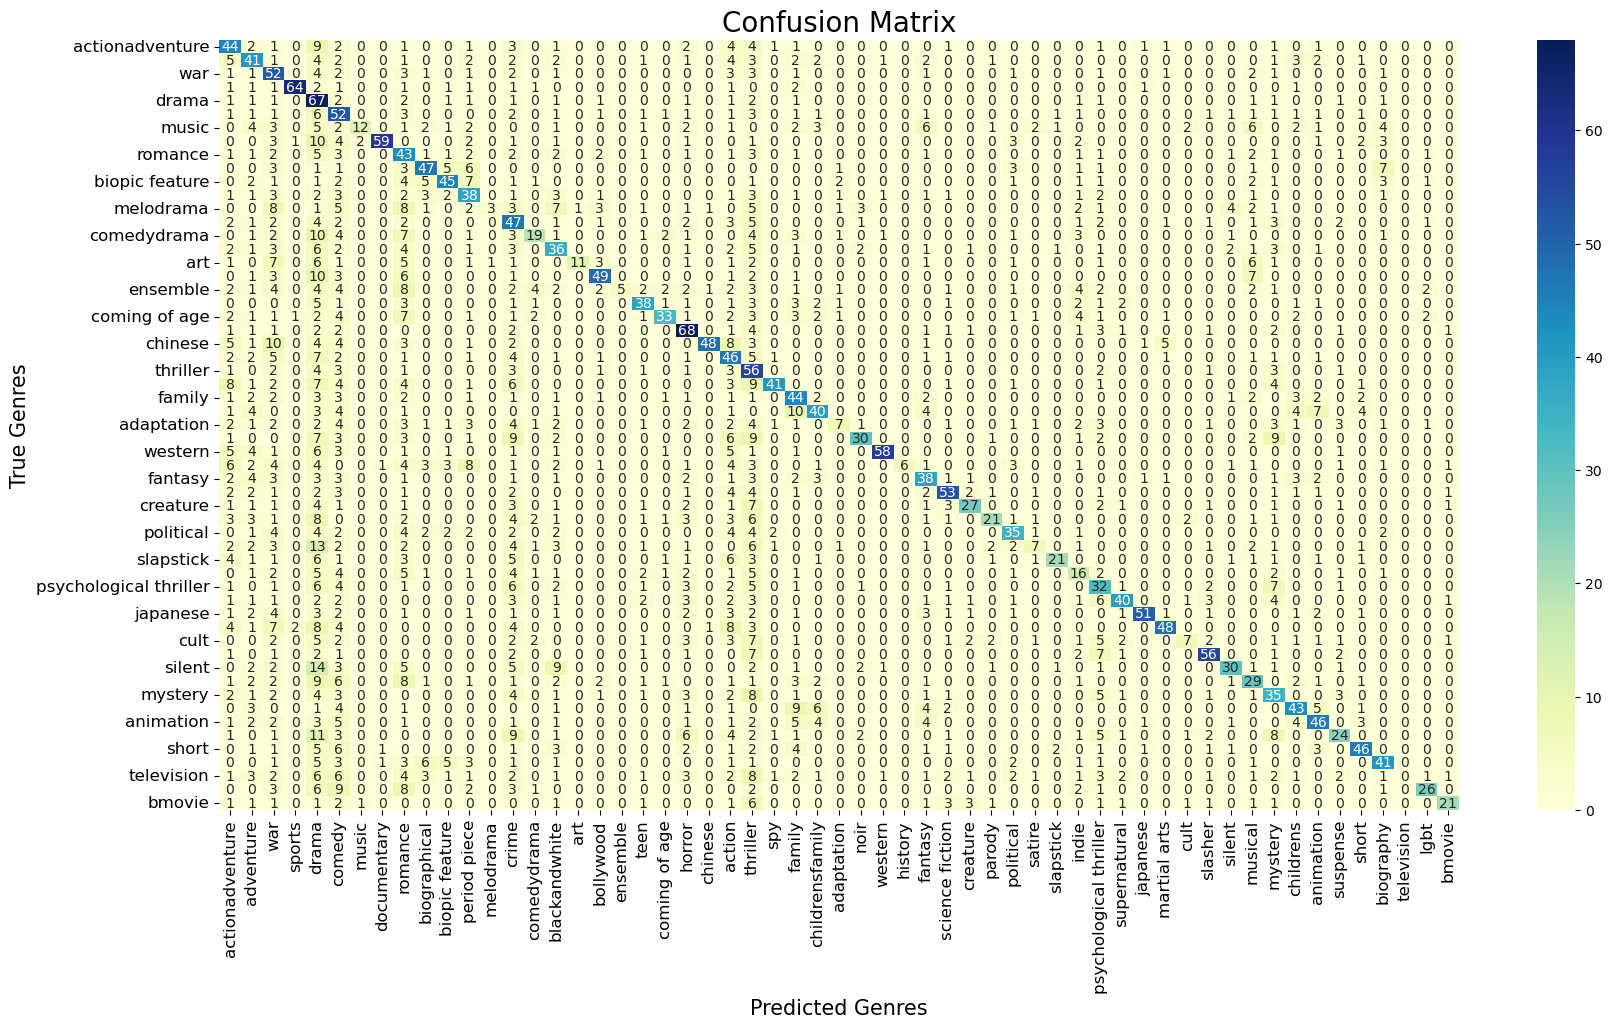

In [73]:
conf_mat,normal_conf_mat = mlcm.cm(df_test['labels'],pred_list,False)

one_vs_rest = mlcm.stats(conf_mat,False)

colnames = unique_genres + ['NPL']
rownames = unique_genres + ['NTL']


#make dataframe from confusion matrix
df_confusion = pd.DataFrame(normal_conf_mat, columns=colnames, index=rownames)
df_confusion.drop('NTL', inplace=True)
df_confusion.drop('NPL', axis=1, inplace=True)

#plot df_confusion
plt.figure(figsize = (20,10))
sns.heatmap(df_confusion, annot=True, cmap="YlGnBu")
plt.title('Confusion Matrix', fontsize=20)
plt.xlabel('Predicted Genres', fontsize=15)
plt.ylabel('True Genres', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


### Rest vs All plots

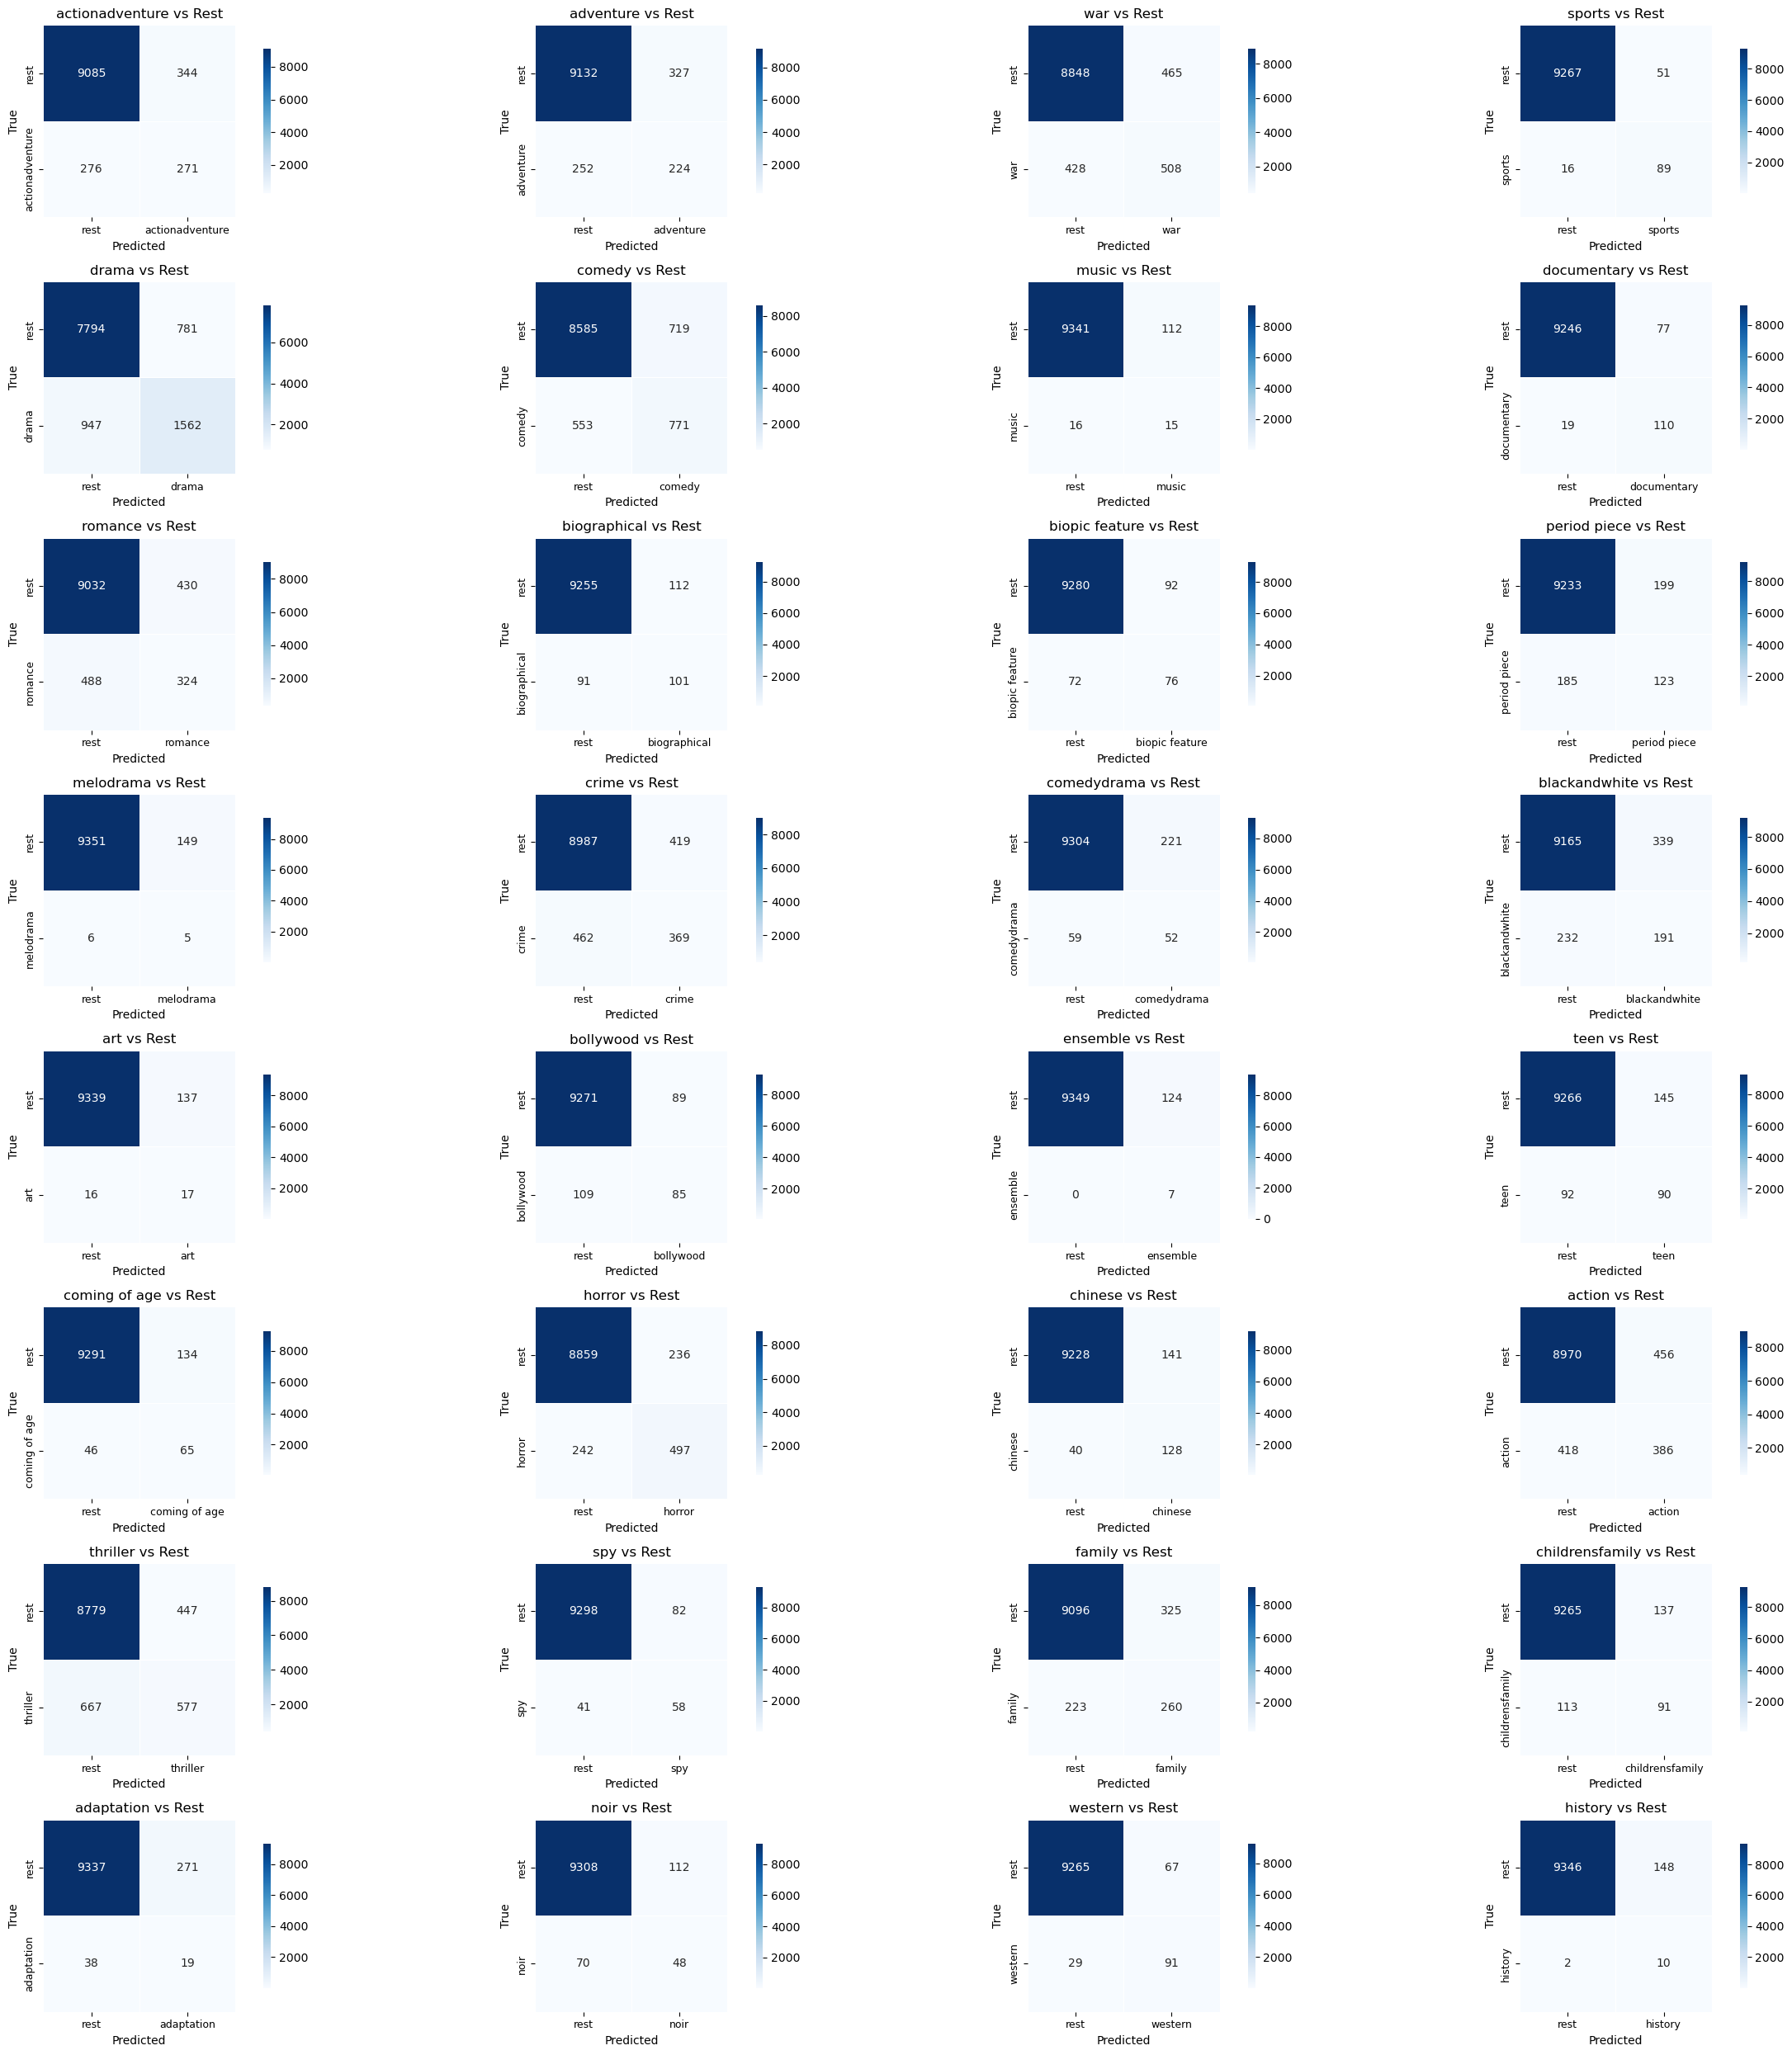

In [77]:

plt.figure(figsize=(25, 25))


n=32
#  first n
for i in range(n):  
    #column names
    colnames = ['rest', unique_genres[i]]
    
    #DataFrame
    df1 = pd.DataFrame(one_vs_rest[i], columns=colnames, index=['rest' , unique_genres[i]]).transpose()

    ax = plt.subplot(int(n/4), 4, i + 1)
    
    #heatmap
    sns.heatmap(df1, annot=True, fmt="d", cmap="Blues", square=True, linewidths=.5, cbar_kws={"shrink": .75})

    # Titles and labels
    ax.set_title(f'{unique_genres[i]} vs Rest', fontsize=12)
    ax.set_xlabel('Predicted', fontsize=10)
    ax.set_ylabel('True', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=9)

plt.tight_layout()
plt.show()
